In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from common_variables import *
from time_series import *

In [2]:
epochs = 200
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
df = pd.read_csv(train_time_series_path, dayfirst=True, 
    index_col=['Date'], parse_dates=['Date'])
df

,HLAvg,MA,Returns
Date,,,
2010-01-01 00:22:00,1.616650,1.616690,-0.000003
2010-01-01 00:23:00,1.616635,1.616683,-0.000005
2010-01-01 00:24:00,1.616640,1.616676,-0.000004
2010-01-01 00:25:00,1.616650,1.616676,0.000000
2010-01-01 00:26:00,1.616660,1.616679,0.000002
...,...,...,...
2019-04-11 15:19:00,1.308195,1.308318,-0.000023
2019-04-11 15:20:00,1.308060,1.308291,-0.000021
2019-04-11 15:21:00,1.308005,1.308272,-0.000014


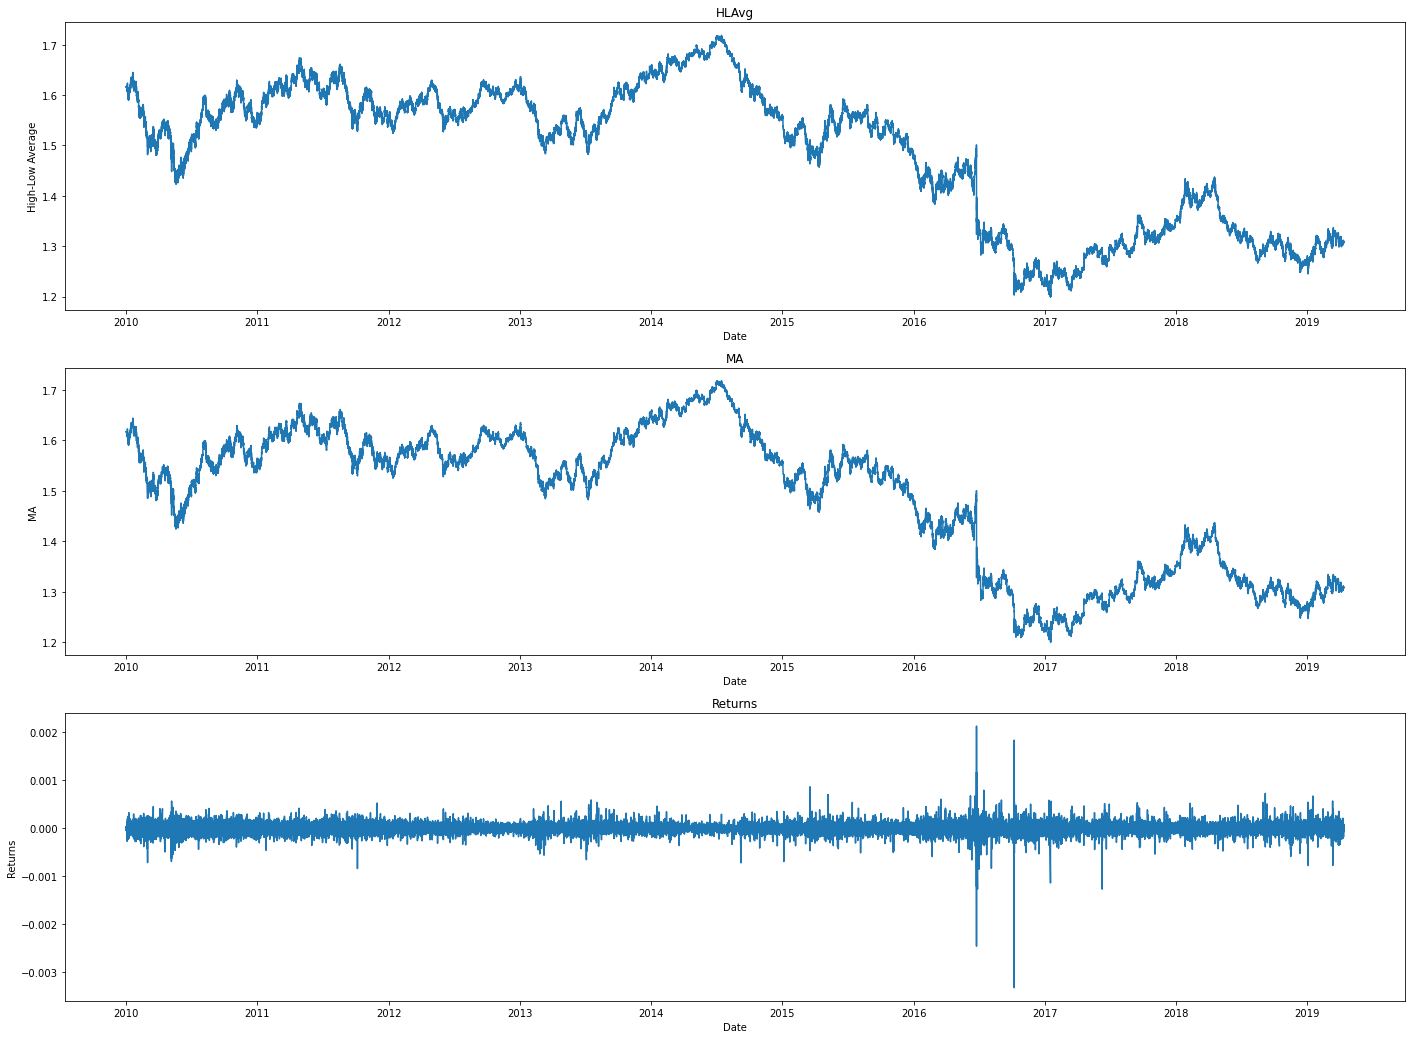

In [4]:
fig = plt.figure(figsize=(24, 18))
ax1, ax2, ax3 = fig.subplots(3)
ax1.set_title('HLAvg')
ax1.set(xlabel='Date', ylabel='High-Low Average')
ax1.plot(df['HLAvg'])
ax2.set_title('MA')
ax2.set(xlabel='Date', ylabel='MA')
ax2.plot(df['MA'])
ax3.set_title('Returns')
ax3.set(xlabel='Date', ylabel='Returns')
ax3.plot(df['Returns'])

In [5]:
scaler = MinMaxScaler()
train_values = scaler.fit_transform(df[['Returns']].values)

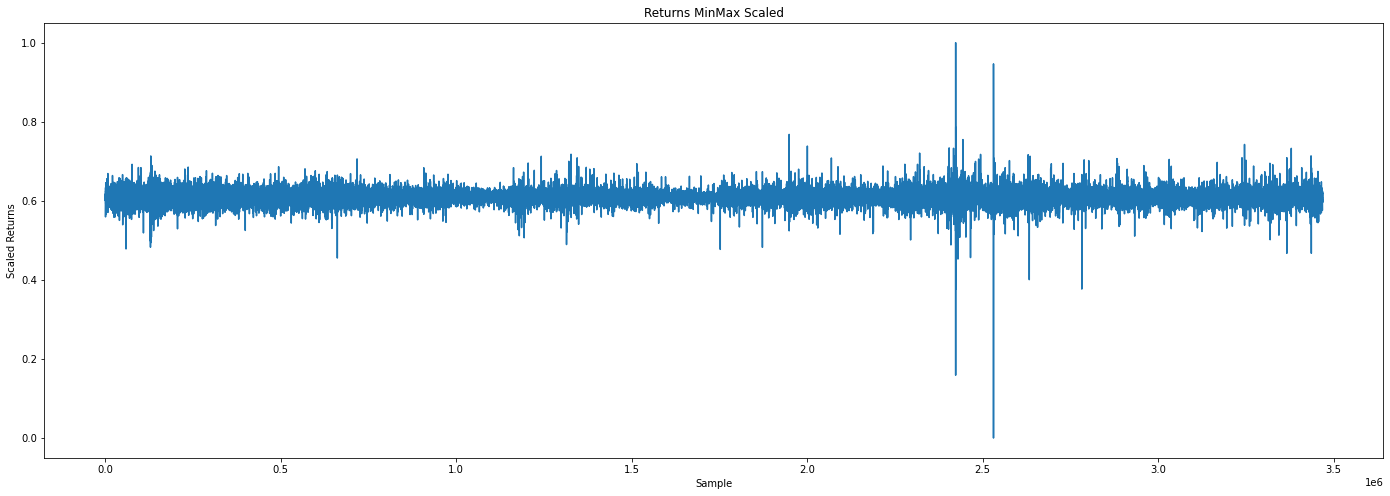

In [6]:
fig = plt.figure(figsize=(24, 8))
ax1 = fig.subplots(1)
ax1.set_title('Returns MinMax Scaled')
ax1.set(xlabel='Sample', ylabel='Scaled Returns')
ax1.plot(train_values)

In [7]:
X, y = get_train(train_values, window_size)

X (3468256, 256, 1), y (3468256, 1)


In [8]:
df_val = pd.read_csv(validate_time_series_path, dayfirst = True, usecols=['Date','Returns'],
    index_col=['Date'], parse_dates=['Date'])
df_val['Scaled'] = scaler.transform(df_val[['Returns']].values)
X_val, y_val = get_val(df_val['Scaled'].values, window_size)

X (262144, 256, 1), y (262144,)


In [9]:
model = Sequential()
model.add(LSTM(76, input_shape=(X.shape[1], 1), return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(1))
optimizer = tf.keras.optimizers.Adam()
model.compile(loss="mse", optimizer=optimizer)

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 76)                23712     
_________________________________________________________________
dropout (Dropout)            (None, 76)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 77        
Total params: 23,789
Trainable params: 23,789
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
history = model.fit(X, y, validation_data=(X_val, y_val), epochs = epochs, batch_size = batch_size, shuffle=False, verbose = 2)

Epoch 1/200
108383/108383 - 1612s - loss: 5.8491e-05 - val_loss: 3.5835e-06
Epoch 2/200
108383/108383 - 1627s - loss: 7.1290e-06 - val_loss: 4.1418e-06
Epoch 3/200
108383/108383 - 1497s - loss: 7.7302e-06 - val_loss: 4.6529e-06
Epoch 4/200
108383/108383 - 1585s - loss: 7.5302e-06 - val_loss: 4.5125e-06
Epoch 5/200
108383/108383 - 1519s - loss: 7.1521e-06 - val_loss: 4.2004e-06
Epoch 6/200
108383/108383 - 1467s - loss: 7.1676e-06 - val_loss: 3.5713e-06
Epoch 7/200
108383/108383 - 1462s - loss: 6.9627e-06 - val_loss: 3.6976e-06
Epoch 8/200
108383/108383 - 1406s - loss: 6.6150e-06 - val_loss: 3.8583e-06
Epoch 9/200
108383/108383 - 1560s - loss: 6.5336e-06 - val_loss: 3.4553e-06
Epoch 10/200
108383/108383 - 1521s - loss: 6.2575e-06 - val_loss: 3.2694e-06
Epoch 11/200
108383/108383 - 1523s - loss: 6.0991e-06 - val_loss: 3.3916e-06
Epoch 12/200
108383/108383 - 1530s - loss: 6.4586e-06 - val_loss: 3.1961e-06
Epoch 13/200
108383/108383 - 1540s - loss: 5.9549e-06 - val_loss: 3.3495e-06
Epoch 14

In [12]:
save_model(model, model_path)
joblib.dump(scaler, scaler_path) 

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/gbpusd-32-256-14\assets


['scalers/gbpusd-32-256-14.bin']

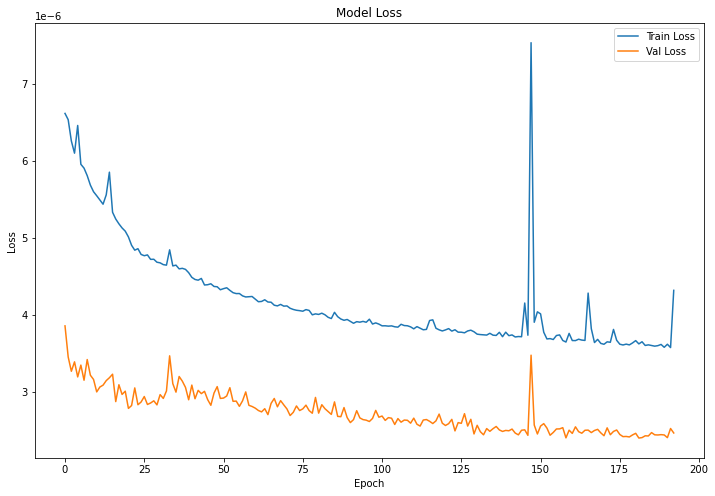

In [13]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.subplots(1)
ax1.set_title('Model Loss')
ax1.set(xlabel='Epoch', ylabel='Loss')
ax1.plot(history.history['loss'][7:], label='Train Loss')
ax1.plot(history.history['val_loss'][7:], label='Val Loss')
ax1.legend()